# LLM Basics

[![Open In Colab - ml_basics](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/proloy79/attoLLM/blob/main/notebooks/llm_basics.ipynb)

In [1]:
from pathlib import Path
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import os 

plt.style.use('seaborn-v0_8')
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

def in_colab():
    return 'google.colab' in sys.modules

if in_colab():
    # --- Colab‑only setup ---
    print("Running in Colab — setting up environment")
    if not os.path.exists('/content/attoLLM'):
      !git clone https://github.com/proloy79/attoLLM.git
    !pip install -e /content/attoLLM
    sys.path.append('/content/attoLLM/src')

else:
    print("Running locally — skipping Colab setup")


Running locally — skipping Colab setup


## 1) Play with the simple tokenizer

In [2]:
from attollm.simple_tokenizer import SimpleTokenizer
"""
Create a vocab from mini.txt using char tokenization.
Then call the tokenizer to encode the provided text
"""
path = '/content/attoLLM/data/raw/mini.txt' if in_colab() else '../data/raw/mini.txt'
text = Path(path).read_text(encoding="utf-8")
tok = SimpleTokenizer.from_text(text, level='char')
ids = tok.encode('Hello world buddy.') # Text -> ids
print(ids)
V=len(tok.vocab)
print('vocab items count(V): ', V)
print('decode will drop chars b,u,y as they are not in mini.txt and only see the chars that are in the vocab')
text=tok.decode(ids)
print(text)

[7, 3, 2, 2, 4, 5, 10, 4, 6, 2, 8, 5, 1, 1, 8, 8, 1, 9]
vocab items count(V):  17
decode will drop chars b,u,y as they are not in mini.txt and only see the chars that are in the vocab
Hello world dd.


## 2) Combined mask - right padding + causal

The combined mask(right padding + causal) sets a default value(0 in the example below) to empty points, so that they do not interfere in the actual weight calculation
tensor([[[1., 0., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0.],
         [1., 1., 1., 1., 1., 1., 0.],
         [1., 1., 1., 1., 1., 1., 1.]]])
torch.Size([2, 7, 7]) 



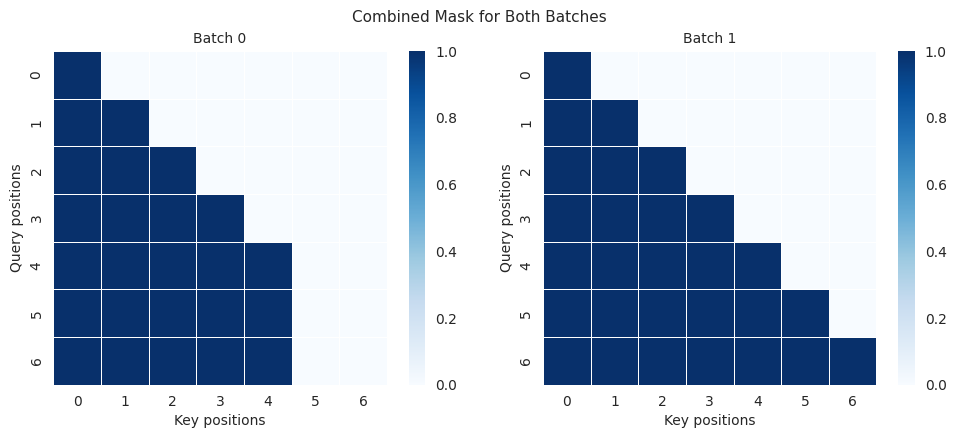


The blank (light) cells correspond to padded positions. These positions are masked out, so the model assigns them zero attention weight.

In a combined mask, each row represents how far a token can attend into the past. Lower rows correspond to later tokens, so they have more allowed attention positions, which appear as more colored cells. Padded rows remain empty because they are fully masked out.


In [3]:
from attollm.embedding_block import EmbeddingBlock

batch = [tok.encode('Hello'), tok.encode('vectors')]
combined_mask = EmbeddingBlock.create_combined_mask(tok.pad, batch)
print('The combined mask(right padding + causal) sets a default value(0 in the example below) to empty points, so that they do not interfere in the actual weight calculation')
print(combined_mask)
print(combined_mask.shape,"\n")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for b in range(2):
    sns.heatmap(
        combined_mask[b].detach().cpu(),
        cmap="Blues",
        square=True,
        cbar=True,
        ax=axes[b],
        linewidths=0.5,        # thickness of grid lines
        linecolor="white"
    )
    axes[b].set_title(f"Batch {b}", fontsize=10)
    axes[b].set_xlabel("Key positions", fontsize=10)
    axes[b].set_ylabel("Query positions", fontsize=10)


plt.tight_layout()
fig.suptitle("Combined Mask for Both Batches", fontsize=11, y=1.05)
plt.show()

print("\nThe blank (light) cells correspond to padded positions. These positions are masked out, so the model assigns them zero attention weight.")
print("\nIn a combined mask, each row represents how far a token can attend into the past. Lower rows correspond to later tokens, so they have more allowed attention positions, which appear as more colored cells. Padded rows remain empty because they are fully masked out.")


## 3) Prepare feed for MHA

In [4]:
from attollm.attention import scaled_dot_product_attention

lines = text.splitlines()

batch_ids = [tok.encode(line) for line in lines]
max_len = max(len(seq) for seq in batch_ids)
mask = EmbeddingBlock.create_combined_mask(tok.pad, batch_ids)
ids = EmbeddingBlock.pad_batch_ids(tok.pad, batch_ids)

d_model = 16
print('No of params(d_model): ', d_model)
embed = EmbeddingBlock(len(tok.vocab), d_model, max_len)
x = embed(ids)   # (B, T, D)

# Attention
q = x; k = x; v = x
scores, weights, y = scaled_dot_product_attention(q, k, v, mask)

B=len(lines)
print('No of batches(B): ', B)
T=mask.size(1)
print('No of timesteps(T): ', T)

print('mha input shape[B,T,d_model]: ', y.shape)

No of params(d_model):  16
No of batches(B):  1
No of timesteps(T):  15
mha input shape[B,T,d_model]:  torch.Size([1, 15, 16])


## 4) Play with MHA

In [5]:
from attollm.mha import MultiHeadAttention

num_heads=4

print('dropout helps regularize the output by randomly dropping a % of attentions')
dropout=0.1

mha = MultiHeadAttention(d_model, num_heads, .1)
print('mha takes the input, projects it into Q, K, and V, splits each into multiple heads of size d_model/num_heads, performs scaled dot‑product attention in each head, then combines all heads back to the original shape')
mha_out=mha(y, mask)

print('mha output is same shape as single linear feed : [B,T,d_model]')
print('mha output shape: ', mha_out.shape)

dropout helps regularize the output by randomly dropping a % of attentions
mha takes the input, projects it into Q, K, and V, splits each into multiple heads of size d_model/num_heads, performs scaled dot‑product attention in each head, then combines all heads back to the original shape
mha output is same shape as single linear feed : [B,T,d_model]
mha output shape:  torch.Size([1, 15, 16])


## 5) Tranformer Block(MHA->Norm->FF->Norm->LM Head)

In [6]:
from attollm.transformer_block import TransformerBlock

d_ff=2*d_model
transform = TransformerBlock(d_model, num_heads, d_ff, V, .1,)
logits=transform(y)
print('transform block output will be projected as [B,T,V]')
print('logits shape: ', logits.shape)

print('next step will be to pass targets so that loss can be computed and gradient descent applied to train this llm to predict what comes next')
print('also try Weight Tying ie setting the embedded weights to the final LM head weights')

transform block output will be projected as [B,T,V]
logits shape:  torch.Size([1, 15, 16])
next step will be to pass targets so that loss can be computed and gradient descent applied to train this llm to predict what comes next
also try Weight Tying ie setting the embedded weights to the final LM head weights


## 6) Visualise how backpropagation (loss.backward) reduces loss

In [7]:
w1=torch.tensor([3,1.2])
b1=torch.tensor(0.5)
N=500
X1=torch.randn(N, 2)
y1=X1@w1 + b1+ 0.1 * torch.randn(N)

torch.manual_seed(0)

model = torch.nn.Linear(2, 1)
opt = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

model.train()

print('--------------')
print(f"{'step':<6}{'loss'}")
print('--------------')
for step in range(401):  # Simple training loop
    opt.zero_grad()  # Clear stale gradients
    pred = model(X1).squeeze(-1)  # Forward pass over dataset
    loss = loss_fn(pred, y1)  # Compute scalar loss
    loss.backward()  # Backprop into parameters
    opt.step()  # Apply gradient update
    if step % 50 == 0:
        print(f"{step:<6}{loss.item():.4f}")

print('loss reduces with propagation and coverges to min after ~350 steps')

--------------
step  loss
--------------
0     11.5322
50    1.3609
100   0.1692
150   0.0286
200   0.0119
250   0.0099
300   0.0097
350   0.0096
400   0.0096
loss reduces with propagation and coverges to min after ~350 steps
